In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.4.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Fetched 338 kB in 2s (144 kB/s)
Reading package lists... Done


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [3]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataFrame Basics").getOrCreate()

In [4]:
# Read the data from S3 Buckets
from pyspark import SparkFiles
url = "./heart.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get('heart.csv'), sep=',', header = True, ignoreLeadingWhiteSpace=True)

# Show DataFrame
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|      1|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|      0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|      1|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|
| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    2|  0|   3|

In [5]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [6]:
result_pdf = df.select("*").toPandas()

In [32]:
result_pdf

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [33]:
result_pdf.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [34]:
result_pdf['age'] = result_pdf['age'].astype(int)
result_pdf['sex'] = result_pdf['sex'].astype(int)
result_pdf['cp'] = result_pdf['cp'].astype(int)
result_pdf['trestbps'] = result_pdf['trestbps'].astype(int)
result_pdf['chol'] = result_pdf['chol'].astype(int)
result_pdf['fbs'] = result_pdf['fbs'].astype(int)
result_pdf['restecg'] = result_pdf['restecg'].astype(int)
result_pdf['thalach'] = result_pdf['thalach'].astype(int)
result_pdf['exang'] = result_pdf['exang'].astype(int)
result_pdf['oldpeak'] = result_pdf['oldpeak'].astype(float)
result_pdf['slope'] = result_pdf['slope'].astype(int)
result_pdf['ca'] = result_pdf['ca'].astype(int)
result_pdf['thal'] = result_pdf['thal'].astype(int)
result_pdf['target'] = result_pdf['target'].astype(int)

In [35]:
result_pdf.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

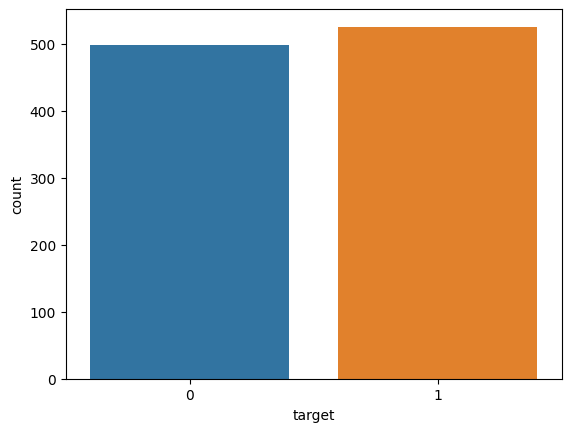

In [36]:
sns.countplot(data=result_pdf,x='target');

<Axes: >

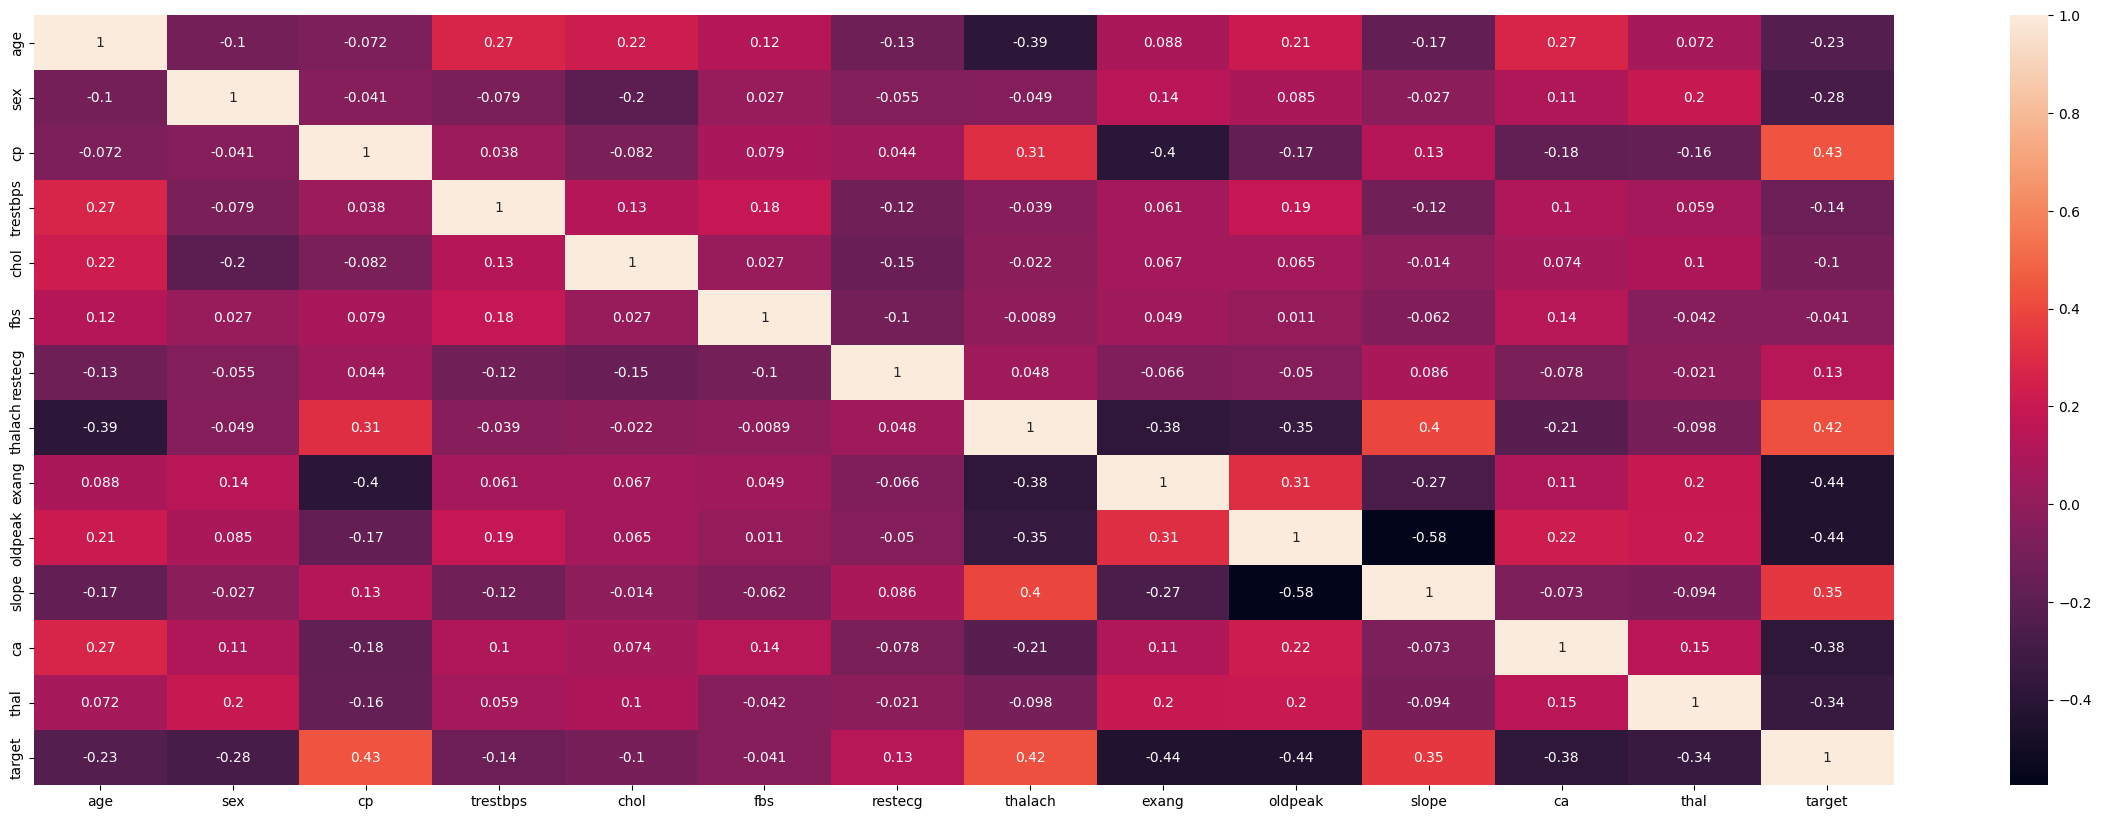

In [37]:
fig = plt.figure(figsize=(30,10))
sns.heatmap(data=result_pdf.corr(),annot=True)
## Cp,thalach y slope son las columnas mas significativas relacionadas al target.
## Hay que hacer pruebas relacionadas quitnado las demás columnas a ver que sale.

In [75]:
# Split our preprocessed data into our features and target arrays
# Separate features (X) and target (y)
X = result_pdf.drop('target', axis=1)
y = result_pdf['target']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)
#, random_state=50
# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (768, 13)
X_test shape: (257, 13)
y_train shape: (768,)
y_test shape: (257,)


In [77]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Compile, Train and Evaluate the Model

In [78]:
# ATTEMPT 1
from keras.layers import Activation, Dense
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# Number of input features
input_features = len(X_train_scaled[0])

# First hidden layer
nn.add(Dense(units=80, input_dim=input_features, activation='relu'))

# Second hidden layer
nn.add(Dense(units=30, activation='relu'))

# Output layer
nn.add(Dense(units=1, activation='tanh'))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 80)                1120      
                                                                 
 dense_34 (Dense)            (None, 30)                2430      
                                                                 
 dense_35 (Dense)            (None, 1)                 31        
                                                                 
Total params: 3,581
Trainable params: 3,581
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Train the model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint callback
checkpoint_path = "model_checkpoint.h5"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)

# Train the model
model_history = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], validation_split=0.1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


 1/22 [>.............................] - ETA: 16s - loss: 6.7055e-08 - accuracy: 0.4375
Epoch 1: val_loss improved from inf to 0.00000, saving model to model_checkpoint.h5
22/22 [==============================] - 1s 12ms/step - loss: 6.0726e-08 - accuracy: 0.4906 - val_loss: 6.0379e-08 - val_accuracy: 0.4935
Epoch 2/100
 1/22 [>.............................] - ETA: 0s - loss: 5.5879e-08 - accuracy: 0.5312
Epoch 2: val_loss did not improve from 0.00000
22/22 [==============================] - 0s 3ms/step - loss: 6.0726e-08 - accuracy: 0.4906 - val_loss: 6.0379e-08 - val_accuracy: 0.4935
Epoch 3/100
19/22 [========================>.....] - ETA: 0s - loss: 6.0585e-08 - accuracy: 0.4918
Epoch 3: val_loss did not improve from 0.00000
22/22 [==============================] - 0s 5ms/step - loss: 6.0726e-08 - accuracy: 0.4906 - val_loss: 6.0379e-08 - val_accuracy: 0.4935
Epoch 4/100
 1/22 [>.............................] - ETA: 0s - loss: 5.5879e-08 - accuracy: 0.5312
Epoch 4: val_loss did not

In [80]:
# ATTEMPT 2
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# Number of input features
input_features = len(X_train_scaled[0])

# First hidden layer
nn.add(Dense(units=100, input_dim=input_features, activation='relu'))

# Second hidden layer
nn.add(Dense(units=80, activation='relu'))

# Third hidden layer
nn.add(Dense(units=30, activation='relu'))

# Output layer , we need to use softmax because
nn.add(Dense(units=50, activation='softmax'))

# Check the structure of the model
nn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               1400      
                                                                 
 dense_37 (Dense)            (None, 80)                8080      
                                                                 
 dense_38 (Dense)            (None, 30)                2430      
                                                                 
 dense_39 (Dense)            (None, 50)                1550      
                                                                 
Total params: 13,460
Trainable params: 13,460
Non-trainable params: 0
_________________________________________________________________


In [81]:
# Compile the model
nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
# Train the model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint callback
checkpoint_path = "model_checkpoint.h5"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)

# Train the model
model_history = nn.fit(X_train_scaled, y_train, epochs=18, callbacks=[cp_callback], validation_split=0.1)

Epoch 1/18
12/22 [===============>..............] - ETA: 0s - loss: 3.6157 - accuracy: 0.2005     
Epoch 1: val_loss improved from inf to 2.20660, saving model to model_checkpoint.h5
22/22 [==============================] - 1s 18ms/step - loss: 3.2366 - accuracy: 0.3821 - val_loss: 2.2066 - val_accuracy: 0.6234
Epoch 2/18
14/22 [==================>...........] - ETA: 0s - loss: 1.4697 - accuracy: 0.6317
Epoch 2: val_loss improved from 2.20660 to 0.62870, saving model to model_checkpoint.h5
22/22 [==============================] - 0s 7ms/step - loss: 1.2156 - accuracy: 0.6657 - val_loss: 0.6287 - val_accuracy: 0.7403
Epoch 3/18
13/22 [================>.............] - ETA: 0s - loss: 0.5199 - accuracy: 0.8293
Epoch 3: val_loss improved from 0.62870 to 0.45018, saving model to model_checkpoint.h5
22/22 [==============================] - 0s 7ms/step - loss: 0.4748 - accuracy: 0.8394 - val_loss: 0.4502 - val_accuracy: 0.8182
Epoch 4/18
17/22 [======================>.......] - ETA: 0s - los

In [83]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

9/9 - 0s - loss: 0.2105 - accuracy: 0.9144 - 34ms/epoch - 4ms/step
Loss: 0.2105361670255661, Accuracy: 0.9143968820571899


In [84]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC

# Model -  Support Vector Classificator
svc = SVC(C=1.5)
svc.fit(X_train_scaled, y_train)
print(svc.score(X_test_scaled, y_test))

0.9182879377431906


              precision    recall  f1-score   support

           0       0.92      0.90      0.91       122
           1       0.91      0.93      0.92       135

    accuracy                           0.92       257
   macro avg       0.92      0.92      0.92       257
weighted avg       0.92      0.92      0.92       257



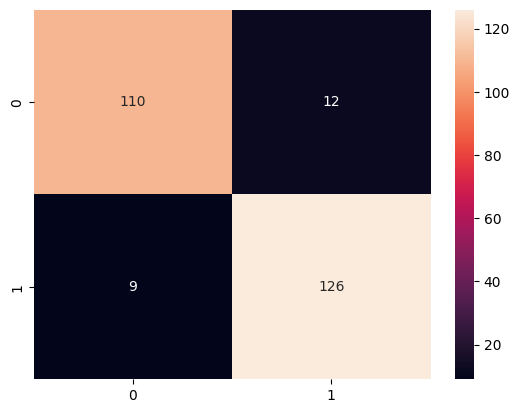

In [85]:
# Confusion Matrix
cnf = confusion_matrix(y_test, svc.predict(X_test_scaled))
sns.heatmap(cnf, annot=True, fmt='.0f')

print(classification_report(y_test, svc.predict(X_test_scaled)))

In [131]:
# Atempt 3
#X = result_pdf.drop('target', axis=1)
X = result_pdf[['cp','thalach','slope']]
y = result_pdf['target']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)
#, random_state=0

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (768, 3)
X_test shape: (257, 3)
y_train shape: (768,)
y_test shape: (257,)


In [132]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# Number of input features
input_features = len(X_train_scaled[0])

# First hidden layer
nn.add(Dense(units=100, input_dim=input_features, activation='relu'))

# Second hidden layer
nn.add(Dense(units=80, activation='relu'))

# Third hidden layer
nn.add(Dense(units=30, activation='relu'))

# Output layer , we need to use softmax because
nn.add(Dense(units=50, activation='softmax'))

# Check the structure of the model
nn.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 100)               1400      
                                                                 
 dense_90 (Dense)            (None, 80)                8080      
                                                                 
 dense_91 (Dense)            (None, 30)                2430      
                                                                 
 dense_92 (Dense)            (None, 50)                1550      
                                                                 
Total params: 13,460
Trainable params: 13,460
Non-trainable params: 0
_________________________________________________________________


In [133]:
# Compile the model
nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [134]:
# Train the model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint callback
checkpoint_path = "model_checkpoint.h5"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)

# Train the model
model_history = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], validation_split=0.1)

Epoch 1/100
17/22 [======================>.......] - ETA: 0s - loss: 3.5310 - accuracy: 0.1765
Epoch 1: val_loss improved from inf to 2.50166, saving model to model_checkpoint.h5
22/22 [==============================] - 4s 44ms/step - loss: 3.3662 - accuracy: 0.2677 - val_loss: 2.5017 - val_accuracy: 0.4805
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 1.4447 - accuracy: 0.5312
Epoch 2: val_loss improved from 2.50166 to 0.79549, saving model to model_checkpoint.h5
22/22 [==============================] - 0s 16ms/step - loss: 1.4260 - accuracy: 0.5282 - val_loss: 0.7955 - val_accuracy: 0.4286
Epoch 3/100
15/22 [===================>..........] - ETA: 0s - loss: 0.7162 - accuracy: 0.5542
Epoch 3: val_loss improved from 0.79549 to 0.72650, saving model to model_checkpoint.h5
22/22 [==============================] - 0s 12ms/step - loss: 0.7124 - accuracy: 0.5470 - val_loss: 0.7265 - val_accuracy: 0.4935
Epoch 4/100
13/22 [================>.............] - ETA: 0s - lo

In [135]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

9/9 - 0s - loss: 1.1407 - accuracy: 0.4981 - 35ms/epoch - 4ms/step
Loss: 1.140653371810913, Accuracy: 0.49805447459220886


In [137]:
#nn.summary()

In [138]:
# Model -  Support Vector Classificator
svc = SVC(C=1.5)
svc.fit(X_train_scaled, y_train)
print(svc.score(X_test_scaled, y_test))

0.5252918287937743


              precision    recall  f1-score   support

           0       0.56      0.47      0.51       136
           1       0.50      0.59      0.54       121

    accuracy                           0.53       257
   macro avg       0.53      0.53      0.52       257
weighted avg       0.53      0.53      0.52       257



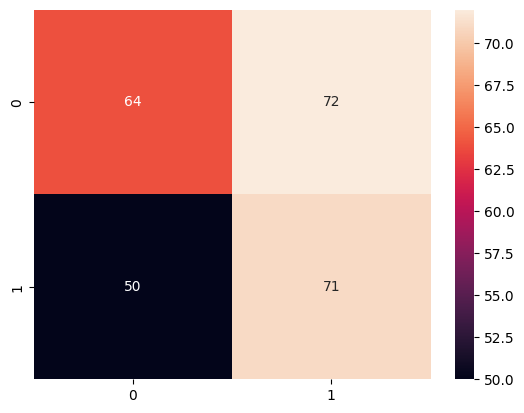

In [139]:
# Confusion Matrix
cnf = confusion_matrix(y_test, svc.predict(X_test_scaled))
sns.heatmap(cnf, annot=True, fmt='.0f')

print(classification_report(y_test, svc.predict(X_test_scaled)))